# VCap Captures

The cell below is used to capture a trace on the VCAP Line. We are going to plot VCC and VCAP on the same graph to see how they overlap with one another. 

adc_src       = clkgen_x1
adc_phase     = 0
adc_freq      = 19000007
adc_rate      = 19000007.0
adc_locked    = True
freq_ctr      = 0
freq_ctr_src  = extclk
clkgen_src    = system
extclk_freq   = 10000000
clkgen_mul    = 19
clkgen_div    = 96
clkgen_freq   = 19000000.0
clkgen_locked = True



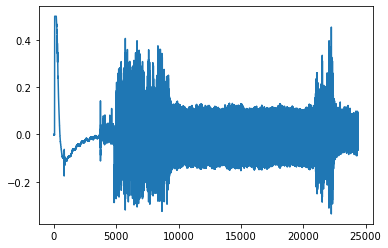

True

In [4]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import time

vcap_traces = []
# Connect to CW LITE
scope = cw.scope(scope_type=cw.scopes.OpenADC)
# setup scope parameters
scope.gain.gain = 45
scope.adc.samples = 24400
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.clock.clkgen_freq = 19E6
scope.clock.adc_src = "clkgen_x1"
scope.trigger.triggers = "tio4"
time.sleep(1)
print(scope.clock)
# Kill power to MCU, arm the scope
scope.io.target_pwr = False
time.sleep(2)
scope.arm()
scope.io.target_pwr = True
ret = scope.capture()
vcap_traces.append(scope.get_last_trace())
# show an example trace
plt.plot(vcap_traces[0])
plt.show()
# cleanup the connection to the target and scope
scope.dis()

# VCC Captures

The cell below is used to capture a trace on another input (in this case VCC). We are going to plot VCC and VCAP on the same graph to see how they overlap with one another. 

adc_src       = clkgen_x1
adc_phase     = 0
adc_freq      = 9999996
adc_rate      = 9999996.0
adc_locked    = True
freq_ctr      = 0
freq_ctr_src  = extclk
clkgen_src    = system
extclk_freq   = 10000000
clkgen_mul    = 5
clkgen_div    = 48
clkgen_freq   = 10000000.0
clkgen_locked = True



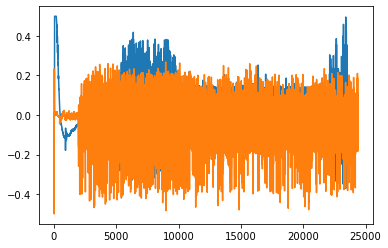

True

In [6]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import time

vcc_trace = []
# Connect to CW LITE
scope = cw.scope(scope_type=cw.scopes.OpenADC)
# setup scope parameters
scope.gain.gain = 45
scope.adc.samples = 24400
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.clock.clkgen_freq = 10E6
scope.clock.adc_src = "clkgen_x1"
scope.trigger.triggers = "tio4"
time.sleep(1)
print(scope.clock)
# Kill power to MCU, arm the scope
scope.io.target_pwr = False
time.sleep(2)
scope.arm()
scope.io.target_pwr = True
ret = scope.capture()
vcc_trace.append(scope.get_last_trace())
# show an example trace
plt.plot(vcap_traces[0])
plt.plot(vcc_trace[0])
plt.show()

# cleanup the connection to the target and scope
scope.dis()

In [5]:
import chipwhisperer.common.results.glitch as glitch
import chipwhisperer as cw
import serial
import time
import sys
import os
import matplotlib.pyplot as plt

scope = None
# SWD device variable
dev = ""
usb_path = "/dev/bus/usb/001/005"

'''
boot_mode_enable
Used to check if boot rom SDP check has been bypassed
1. Reset the STLink adapter using the usbreset program
2. Attempt to communicate with the DAP over SWD
'''
def boot_mode_enable():
    global dev
    import swd
    pc = 0
    try:    
        os.system(f"sudo /home/wrongbaud/vss/research/chipwhisperer-jupyter/usbreset {usb_path}")
        dev = swd.Swd()
        pc = dev.get_version().str
    except:
        del swd
        pass
    return pc

def reboot_flush():            
    global scope
    scope.io.target_pwr = False
    scope.io.nrst = False
    time.sleep(.5)
    scope.io.nrst = "high_z"
    scope.arm()
    scope.io.target_pwr = True

scope = cw.scope(scope_type=cw.scopes.OpenADC)

# Set up scope specific parameters
scope.trigger.triggers = 'tio4'
scope.gain.gain = 45
scope.adc.samples = 24400
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.clock.clkgen_freq = 100E6
scope.adc.decimate = 10
scope.clock.adc_src = "clkgen_x1"
time.sleep(1)
scope.glitch.output = "glitch_only" # glitch_out = clk ^ glitch
scope.glitch.trigger_src = "ext_single" # glitch only after scope.arm() called
scope.io.glitch_lp = True
scope.io.glitch_hp = True

pwr_trace = []
g_step = 1
gc = glitch.GlitchController(groups=["success", "failure"], parameters=["width", "offset", "ext_offset"])
gc.set_global_step(g_step)
gc.set_range("width", 40, 40)
gc.set_range("offset", -45, -45)
gc.set_range("ext_offset", 15000, 15550)
reboot_flush()
# How many times we attempt each configuration
sample_size = 5
# How many clock cycles we pull low for
scope.glitch.repeat=8192
offsets = []
for glitch_setting in gc.glitch_values():
    scope.glitch.width = glitch_setting[0]
    scope.glitch.offset = glitch_setting[1]
    scope.glitch.ext_offset = glitch_setting[2]
    successes = 0
    failures = 0
    print("PLZ")
    print(scope.glitch.ext_offset)
    for i in range(sample_size):
        # Reboot target, arm scope, wait for glitch
        reboot_flush()
        # Allow target time to initialize
        time.sleep(2)
        # Reset glitch lines as reccomended in docs
        scope.io.glitch_hp = False
        scope.io.glitch_hp = True
        scope.io.glitch_lp = False
        scope.io.glitch_lp = True
        # Check to see if glitch was successful
        x = boot_mode_enable()
        if x:
            print("Success! -- offset = {}, width = {}, ext_offset = {}".format(scope.glitch.offset, scope.glitch.width, scope.glitch.ext_offset))
            successes += 1
            break
    if successes > 0:                
        print("successes = {}, failures = {}, offset = {}, width = {}, ext_offset = {}".format(successes, failures, scope.glitch.offset, scope.glitch.width, scope.glitch.ext_offset))
        break

PLZ
15000
PLZ
15001
PLZ
15002
PLZ
15003
PLZ
15004
PLZ
15005
PLZ
15006
PLZ
15007
PLZ
15008
PLZ
15009


KeyboardInterrupt: 